# Imports and set up

In [1]:
%%capture
! pip install catboost optuna shap-hypetune

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix

import optuna

In [3]:
SEED = 42

In [4]:
BIOPPYTHON_FEATURE_NAMES = [
    'molecular_weight',
    'aromaticity',
    'instability_index',
    'isoelectric_point',
    'helix_fraction',
    'turn_fraction',
    'sheet_fraction',
    'molar_extinction_coefficient_reduced',
    'molar_extinction_coefficient_oxidized',
    'gravy',
    'charge_at_ph'
]

# Classification

In [5]:
binary_prepocessed = pd.read_csv('/data/notebook_files/binary_preprocessed.csv')

In [6]:
binary_basic_features = pd.read_csv('/data/notebook_files/binary_basic_features_.csv')

In [7]:
full_binary_df_with_aa = pd.concat([
    binary_prepocessed.reset_index().drop(columns='index') ,
    binary_basic_features[BIOPPYTHON_FEATURE_NAMES + ['sequence_len']].reset_index().drop(columns='index') 
], axis=1, ignore_index=False)

full_binary_df_with_aa = full_binary_df_with_aa.loc[:,~full_binary_df_with_aa.columns.duplicated()]

full_binary_df_with_aa

,Unnamed: 0,uptake_type,sequence,biotin_o,molecular_weight,aromaticity,instability_index,isoelectric_point,helix_fraction,turn_fraction,sheet_fraction,molar_extinction_coefficient_reduced,molar_extinction_coefficient_oxidized,gravy,charge_at_ph,sequence_len
0,0,0,GTRTDSREDEI,0,1278.2835,0.000000,71.409091,4.316717,0.181818,0.363636,0.272727,0,0,-1.918182,-2.232056,11
1,1,0,VLPAWQGYHPM,0,1298.5111,0.181818,38.136364,6.710264,0.272727,0.272727,0.363636,6990,6990,-0.072727,-0.179836,11
2,2,0,AQPLWGLLSFLPL,0,1454.7531,0.153846,49.100000,5.570017,0.461538,0.307692,0.538462,5500,5500,1.138462,-0.204125,13
3,3,0,LPLESGNCAPF,0,1147.3007,0.090909,68.790909,4.050028,0.363636,0.454545,0.272727,0,0,0.300000,-1.246989,11
4,4,0,LFWLGWLGML,0,1235.5379,0.300000,46.020000,5.525000,0.500000,0.200000,0.700000,11000,11000,1.730000,-0.239898,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116,1559,1,KRRIRRERNKMAAAKSRNRRRELTDTGC,0,3429.9483,0.000000,134.914286,11.910421,0.357143,0.178571,0.142857,0,0,-1.935714,8.753855,28
3117,1560,1,WLRRIKAWLRRIKALNRQLGVAA,0,2789.3795,0.086957,87.843478,11.999968,0.434783,0.086957,0.391304,11000,11000,-0.169565,6.758054,23
3118,1561,1,GRKKRRQRRRPP,0,1590.8850,0.000000,227.683333,11.999968,0.166667,0.250000,0.000000,0,0,-3.491667,7.758044,12
3119,1562,1,RRRRRRRRR,0,1423.6866,0.000000,518.044444,11.999968,0.000000,0.000000,0.000000,0,0,-4.500000,8.760012,9


In [8]:
full_binary_df_with_aa = full_binary_df_with_aa.drop(columns=['Unnamed: 0'])

In [9]:
def add_aa_percentages(df, aa_list, seq_col_name = 'sequence'):
    """
    Adds columns to the DataFrame with the percentage of each specified amino acid in the sequence.

    Parameters:
    df (pd.DataFrame): DataFrame containing the sequences.
    aa_list (list of str): List of amino acids to compute percentages for.

    Returns:
    pd.DataFrame: DataFrame with additional columns for each amino acid percentage.
    """
    for aa in aa_list:
        df[aa + '_percentage'] = df[seq_col_name].apply(lambda x: x.count(aa) / len(x) * 100 if len(x) > 0 else 0)
    return df

In [10]:
amino_acids = ['R', 'K', 'S', 'E']

In [11]:
add_aa_percentages(full_binary_df_with_aa, amino_acids)

,uptake_type,sequence,biotin_o,molecular_weight,aromaticity,instability_index,isoelectric_point,helix_fraction,turn_fraction,sheet_fraction,molar_extinction_coefficient_reduced,molar_extinction_coefficient_oxidized,gravy,charge_at_ph,sequence_len,R_percentage,K_percentage,S_percentage,E_percentage
0,0,GTRTDSREDEI,0,1278.2835,0.000000,71.409091,4.316717,0.181818,0.363636,0.272727,0,0,-1.918182,-2.232056,11,18.181818,0.000000,9.090909,18.181818
1,0,VLPAWQGYHPM,0,1298.5111,0.181818,38.136364,6.710264,0.272727,0.272727,0.363636,6990,6990,-0.072727,-0.179836,11,0.000000,0.000000,0.000000,0.000000
2,0,AQPLWGLLSFLPL,0,1454.7531,0.153846,49.100000,5.570017,0.461538,0.307692,0.538462,5500,5500,1.138462,-0.204125,13,0.000000,0.000000,7.692308,0.000000
3,0,LPLESGNCAPF,0,1147.3007,0.090909,68.790909,4.050028,0.363636,0.454545,0.272727,0,0,0.300000,-1.246989,11,0.000000,0.000000,9.090909,9.090909
4,0,LFWLGWLGML,0,1235.5379,0.300000,46.020000,5.525000,0.500000,0.200000,0.700000,11000,11000,1.730000,-0.239898,10,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116,1,KRRIRRERNKMAAAKSRNRRRELTDTGC,0,3429.9483,0.000000,134.914286,11.910421,0.357143,0.178571,0.142857,0,0,-1.935714,8.753855,28,32.142857,10.714286,3.571429,7.142857
3117,1,WLRRIKAWLRRIKALNRQLGVAA,0,2789.3795,0.086957,87.843478,11.999968,0.434783,0.086957,0.391304,11000,11000,-0.169565,6.758054,23,21.739130,8.695652,0.000000,0.000000
3118,1,GRKKRRQRRRPP,0,1590.8850,0.000000,227.683333,11.999968,0.166667,0.250000,0.000000,0,0,-3.491667,7.758044,12,50.000000,16.666667,0.000000,0.000000
3119,1,RRRRRRRRR,0,1423.6866,0.000000,518.044444,11.999968,0.000000,0.000000,0.000000,0,0,-4.500000,8.760012,9,100.000000,0.000000,0.000000,0.000000


<Axes: >

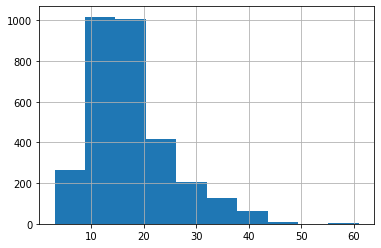

In [12]:
full_binary_df_with_aa.sequence_len.hist()

In [13]:
MAX_LEN = 40

In [14]:
# Custom transformer to extract amino acids at each position
class SequencePositionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, max_len=40):
        self.max_len = max_len
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = []
        for seq in X:
            if len(seq) > self.max_len:
                seq = seq[:self.max_len]  # Truncate sequences longer than max_len
            seq_padded = seq.ljust(self.max_len, 'X')  # Pad sequences shorter than max_len with 'X' (to represent no amino acid)
            X_transformed.append(list(seq_padded))
        return X_transformed
    
# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('seq', Pipeline(steps=[
            ('seq_pos', SequencePositionTransformer(max_len=MAX_LEN)),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), 'sequence')
    ],
    remainder='passthrough'  # Pass through other columns without transformation
)

In [20]:
# # Custom transformer to extract amino acids at each position
# class SequencePositionTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self, max_len=40):
#         self.max_len = max_len
    
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X):
#         X_transformed = []
#         for seq in X:
#             if len(seq) > self.max_len:
#                 seq = seq[:self.max_len]  # Truncate sequences longer than max_len
#             seq_padded = seq.ljust(self.max_len, 'X')  # Pad sequences shorter than max_len with 'X' (to represent no amino acid)
#             X_transformed.append(list(seq_padded))
#         return X_transformed
    
# # Define the ColumnTransformer
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('seq', Pipeline(steps=[
#             ('seq_pos', SequencePositionTransformer(max_len=MAX_LEN)),
#             ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, categories='auto'))  # Use 'auto' for automatic category inference
#         ]), 'sequence'),
#         ('remainder', 'passthrough')
#     ],
#     remainder='passthrough'  # Pass through other columns without transformation
# )

In [21]:
# Encode the target variable
label_encoder = LabelEncoder()
full_binary_df_with_aa['uptake_type'] = label_encoder.fit_transform(full_binary_df_with_aa['uptake_type'])

# Define the features and target
X = full_binary_df_with_aa.drop(columns=['uptake_type'])
y = full_binary_df_with_aa['uptake_type']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier(silent=True, random_seed=SEED))
])

In [19]:
# Fit the model
pipeline.fit(X_train, y_train)

ValueError: ValueError: not enough values to unpack (expected 3, got 2)

In [131]:
# Make predictions
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Evaluate the model
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f'F1 Score: {f1}')
print(f'AUC: {auc}')

F1 Score: 0.8869257950530036
AUC: 0.9556316104158505


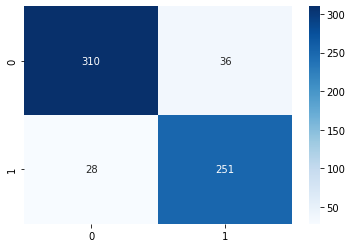

In [132]:
cfm = confusion_matrix(y_pred,y_test)
sns.heatmap(cfm, annot=True, cmap="Blues", fmt='g')
plt.show()

In [133]:
def objective(trial):
    # Define hyperparameters to tune
    params = {
        "iterations": 500,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    # Create the pipeline with tuned CatBoostClassifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', CatBoostClassifier(**params, silent=True))
    ])

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc')

    # Return the average AUC across all folds
    return np.mean(auc_scores)

In [134]:
# Run optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Print best hyperparameters and AUC
print('Best hyperparameters:', study.best_params)
print('Best AUC:', study.best_value)

Best hyperparameters: {'learning_rate': 0.0524623963482218, 'depth': 10, 'subsample': 0.4224345083351122, 'colsample_bylevel': 0.6244444267172016, 'min_data_in_leaf': 58}
Best AUC: 0.9711825567768347


[I 2024-07-22 18:54:32,258] A new study created in memory with name: no-name-fc85d08e-e11c-4504-bb69-ceec3ce02a97
[I 2024-07-22 18:54:49,257] Trial 0 finished with value: 0.958085052584224 and parameters: {'learning_rate': 0.014597203824188339, 'depth': 6, 'subsample': 0.14887629965845545, 'colsample_bylevel': 0.786037433359786, 'min_data_in_leaf': 82}. Best is trial 0 with value: 0.958085052584224.
[I 2024-07-22 18:55:39,656] Trial 1 finished with value: 0.9445759442565536 and parameters: {'learning_rate': 0.0015470271723114542, 'depth': 9, 'subsample': 0.21113092258408872, 'colsample_bylevel': 0.3863732352303563, 'min_data_in_leaf': 2}. Best is trial 0 with value: 0.958085052584224.
[I 2024-07-22 18:56:38,283] Trial 2 finished with value: 0.9455514291359564 and parameters: {'learning_rate': 0.0011063277277986773, 'depth': 10, 'subsample': 0.29096048602323354, 'colsample_bylevel': 0.5028494931566964, 'min_data_in_leaf': 26}. Best is trial 0 with value: 0.958085052584224.
[I 2024-07-22

In [17]:
BEST_PARAMS = {
    'learning_rate': 0.0524623963482218,
    'depth': 10,
    'subsample': 0.4224345083351122,
    'colsample_bylevel': 0.6244444267172016,
    'min_data_in_leaf': 58
}

In [18]:
# Train the final model with the best hyperparameters
best_params = BEST_PARAMS
final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier(**best_params, silent=True))
])
final_model.fit(X_train, y_train)

# Evaluate the final model on the test set
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f'Final F1 Score: {f1}')
print(f'Final AUC: {auc}')

Final F1 Score: 0.9065255731922399
Final AUC: 0.9610230295033297


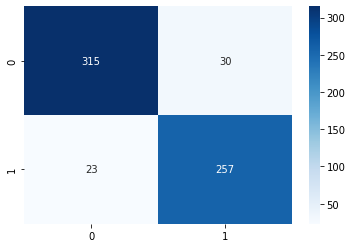

In [30]:
cfm = confusion_matrix(y_pred,y_test)
sns.heatmap(cfm, annot=True, cmap="Blues", fmt='g')
plt.show()

In [23]:
final_model

Pipeline(steps=[('preprocessor',
 ColumnTransformer(remainder='passthrough',
 transformers=[('seq',
 Pipeline(steps=[('seq_pos',
 SequencePositionTransformer()),
 ('onehot',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False))]),
 'sequence')])),
 ('classifier',
 <catboost.core.CatBoostClassifier object at 0x7f03497d6e20>)]) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. Pipeline Pipeline(steps=[('preprocessor',
 ColumnTransformer(remainder='passthrough',
 transformers=[('seq',
 Pipeline(steps=[('seq_pos',
 SequencePositionTransformer()),
 ('onehot',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False))]),
 'sequence')])),
 ('classifier',
 <catboost.core.CatBoostClassifier object at 0x7f03497d6e20>)]) preprocessor: ColumnTransformer ColumnTransformer(remainder='passthrough',
 transformers=[('seq',
 Pipeline(steps=[('seq_pos',
 SequencePositionTransformer()),
 ('onehot',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False))]),
 'sequence')]) seq sequence SequencePositionTransformer SequencePositionTransformer() OneHotEncoder OneHotEncoder(handle_unknown='ignore', sparse_output=False) remainder ['biotin_o', 'molecular_weight', 'aromaticity', 'instability_index', 'isoelectric_point', 'helix_fraction', 'turn_fraction', 'sheet_fraction', 'molar_extinction_coefficient_reduced', 'molar_extinction_coefficient_oxidized', 'gravy', 'charge_at_ph', 'sequence_len', 'R_percentage', 'K_percentage', 'S_percentage', 'E_percentage'] passthrough passthrough CatBoostClassifier <catboost.core.CatBoostClassifier object at 0x7f03497d6e20>

# Feauture importance

In [24]:
import shap

In [25]:
final_model

Pipeline(steps=[('preprocessor',
 ColumnTransformer(remainder='passthrough',
 transformers=[('seq',
 Pipeline(steps=[('seq_pos',
 SequencePositionTransformer()),
 ('onehot',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False))]),
 'sequence')])),
 ('classifier',
 <catboost.core.CatBoostClassifier object at 0x7f03497d6e20>)]) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. Pipeline Pipeline(steps=[('preprocessor',
 ColumnTransformer(remainder='passthrough',
 transformers=[('seq',
 Pipeline(steps=[('seq_pos',
 SequencePositionTransformer()),
 ('onehot',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False))]),
 'sequence')])),
 ('classifier',
 <catboost.core.CatBoostClassifier object at 0x7f03497d6e20>)]) preprocessor: ColumnTransformer ColumnTransformer(remainder='passthrough',
 transformers=[('seq',
 Pipeline(steps=[('seq_pos',
 SequencePositionTransformer()),
 ('onehot',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False))]),
 'sequence')]) seq sequence SequencePositionTransformer SequencePositionTransformer() OneHotEncoder OneHotEncoder(handle_unknown='ignore', sparse_output=False) remainder ['biotin_o', 'molecular_weight', 'aromaticity', 'instability_index', 'isoelectric_point', 'helix_fraction', 'turn_fraction', 'sheet_fraction', 'molar_extinction_coefficient_reduced', 'molar_extinction_coefficient_oxidized', 'gravy', 'charge_at_ph', 'sequence_len', 'R_percentage', 'K_percentage', 'S_percentage', 'E_percentage'] passthrough passthrough CatBoostClassifier <catboost.core.CatBoostClassifier object at 0x7f03497d6e20>

In [ ]:
# Extract the classifier from the pipeline
classifier = final_model.named_steps['classifier']

# Preprocess the training data using the pipeline's preprocessor
X_train_preprocessed = final_model.named_steps['preprocessor'].transform(X_train)

# Initialize the SHAP explainer with the extracted classifier
explainer = shap.Explainer(classifier, X_train_preprocessed)

# Calculate SHAP values
shap_values = explainer(X_train_preprocessed)

 59%|============        | 1468/2496 [03:32<02:28]       

In [ ]:
# Preprocess the training data using the pipeline's preprocessor
X_train_preprocessed = final_model.named_steps['preprocessor'].transform(X_train)

# Initialize the SHAP explainer with the extracted classifier
explainer = shap.Explainer(classifier, X_train_preprocessed)

# Calculate SHAP values
shap_values = explainer(X_train_preprocessed)

# Plot summary plot
shap.summary_plot(shap_values, X_train_preprocessed, plot_type="bar")

# Detailed feature importance plot
shap.summary_plot(shap_values, X_train_preprocessed)

# Genetic alghoritm

In [26]:
!pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 47.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [29]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import random

In [30]:
# Constants (we can tune them)
AMINO_ACIDS = 'ACDEFGHIKLMNPQRSTVWY'
POPULATION_SIZE = 50
SEQUENCE_LENGTH = 20 # This parameter user can change
NUM_GENERATIONS = 50
TOURNAMENT_SIZE = 5
MUTATION_RATE = 0.1

pipeline = final_model

In [45]:
# import pandas as pd
# import numpy as np
# import re
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import FunctionTransformer
# from Bio.SeqUtils.ProtParam import ProteinAnalysis
# from catboost import CatBoostClassifier

# # Custom Transformer to find and add categorical features
# class CategoricalFeatureAdder(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         pass
    
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X):
#         df = X.copy()
#         df['nht_tail'] = df['Sequence'].apply(self.find_nht_tail)
#         df['acylated_terminal'] = df['Sequence'].apply(self.find_acylated_terminal)
#         df['cooh_terminal'] = df['Sequence'].apply(self.find_cooh_terminal)
#         return df
    
#     def find_nht_tail(self, sequence):
#         pattern = r'-NH2$'
#         return 1 if pd.notnull(sequence) and re.search(pattern, sequence) else 0
    
#     def find_acylated_terminal(self, sequence):
#         pattern = r'^(Ac-|\(Acp\)-)'
#         return 1 if pd.notnull(sequence) and re.search(pattern, sequence) else 0
    
#     def find_cooh_terminal(self, sequence):
#         pattern = r'^COOH-'
#         return 1 if pd.notnull(sequence) and re.search(pattern, sequence) else 0

# # Custom Transformer to clean sequences
# class SequenceCleaner(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         pass
    
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X):
#         df = X.copy()
#         df['cleaned_sequence'] = df['Sequence']
#         df['cleaned_sequence'] = df['cleaned_sequence'].apply(self.clean_sequence_nh2)
#         df['cleaned_sequence'] = df['cleaned_sequence'].apply(self.clean_sequence_mpa)
#         df['cleaned_sequence'] = df['cleaned_sequence'].apply(self.clean_sequence_acylated)
#         df['cleaned_sequence'] = df['cleaned_sequence'].apply(self.clean_sequence_cooh)
#         return df
    
#     def clean_sequence_nh2(self, sequence):
#         if pd.notnull(sequence) and sequence.endswith('-NH2'):
#             return sequence[:-4]  # Remove '-NH2'
#         return sequence
    
#     def clean_sequence_mpa(self, sequence):
#         if pd.notnull(sequence) and sequence.startswith('Mpa(luc)-'):
#             return sequence[9:]  # Remove 'Mpa(luc)-'
#         return sequence
    
#     def clean_sequence_acylated(self, sequence):
#         if pd.notnull(sequence):
#             if sequence.startswith('Ac-'):
#                 return sequence[3:]  # Remove 'Ac-'
#             elif sequence.startswith('(Acp)-'):
#                 return sequence[5:]  # Remove '(Acp)-'
#         return sequence
    
#     def clean_sequence_cooh(self, sequence):
#         if pd.notnull(sequence) and sequence.startswith('COOH-'):
#             return sequence[5:]  # Remove 'COOH-'
#         return sequence

# # Custom Transformer to extract features
# class FeatureExtractor(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         pass
    
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X):
#         df = X.copy()
#         return df.drop(columns=['Sequence', 'cleaned_sequence'])

# def calculate_protein_descriptors(sequence):
#     """Calculate descriptors for a given sequence."""
#     analysis = ProteinAnalysis(sequence)
#     descriptors = {
#         'molecular_weight': analysis.molecular_weight(),
#         'aromaticity': analysis.aromaticity(),
#         'instability_index': analysis.instability_index(),
#         'isoelectric_point': analysis.isoelectric_point(),
#         'helix_fraction': analysis.secondary_structure_fraction()[0],
#         'turn_fraction': analysis.secondary_structure_fraction()[1],
#         'sheet_fraction': analysis.secondary_structure_fraction()[2],
#         'molar_extinction_coefficient_reduced': analysis.molar_extinction_coefficient()[0],
#         'molar_extinction_coefficient_oxidized': analysis.molar_extinction_coefficient()[1],
#         'gravy': analysis.gravy(),
#         'sequence_len': len(sequence)
#     }
    
#     # Calculate amino acid percentages
#     aa_counts = {aa: sequence.count(aa) / len(sequence) * 100 for aa in AMINO_ACIDS}
#     descriptors.update(aa_counts)
    
#     return pd.Series(descriptors)

# class ProteinDescriptorExtractor(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         pass
    
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X):
#         df = X.copy()
#         df = df.apply(lambda row: calculate_protein_descriptors(row['cleaned_sequence']), axis=1)
#         return pd.DataFrame(df.tolist())

# # Creating the full pipeline
# preprocessor = Pipeline(steps=[
#     ('categorical_feature_adder', CategoricalFeatureAdder()),
#     ('sequence_cleaner', SequenceCleaner()),
#     ('feature_extractor', FeatureExtractor()),
#     ('descriptor_extractor', ProteinDescriptorExtractor())
# ])

In [52]:
test_df = full_binary_df_with_aa[['sequence', 'uptake_type']].copy()
test_df['Sequence'] = full_binary_df_with_aa.sequence

In [54]:
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('classifier', CatBoostClassifier(**best_params, silent=True))
# ])

# # Process and fit the pipeline
# X = pipeline.fit_transform(test_df)
# print(X)

Error: Error: begin 0, end -1, length 0

# Regression

In [24]:
large_no_conc_basic_features = pd.read_csv('/data/notebook_files/large_no_conc_basic_features.csv')
large_no_conc_preprocessed = pd.read_csv('/data/notebook_files/large_no_conc_preprocessed.csv')

In [25]:
catboost_regresson_df = pd.concat(
    [large_no_conc_basic_features[BIOPPYTHON_FEATURE_NAMES + ['sequence_len']],
     large_no_conc_preprocessed.drop(columns=['Sequence']).set_index(large_no_conc_preprocessed.index)],
    axis=1, ignore_index=False
)
catboost_regresson_df

,molecular_weight,aromaticity,instability_index,isoelectric_point,helix_fraction,turn_fraction,sheet_fraction,molar_extinction_coefficient_reduced,molar_extinction_coefficient_oxidized,gravy,...,Uptake,Units,Time,Temp.,Method,Type,new_uptake,nht_tail,acylated_terminal,cleaned_sequence
0,1339.6033,0.0,257.444444,11.999968,0.222222,0.0,0.0,0,0,-4.255556,...,650,Mean Fluorescence intensity,15.0,23.0,Flow cytometry,Cellular uptake,650.00,0,0,RKKRRQRRR
1,1183.4176,0.0,216.775000,11.999968,0.250000,0.0,0.0,0,0,-4.225000,...,31.25,Mean Fluorescence intensity,10.0,23.0,Flow cytometry,Cellular uptake,31.25,0,0,RKKRRQRR
2,1027.2319,0.0,164.485714,11.999968,0.285714,0.0,0.0,0,0,-4.185714,...,10,Mean Fluorescence intensity,10.0,23.0,Flow cytometry,Cellular uptake,10.00,0,0,RKKRRQR
3,1183.4176,0.0,288.375000,11.999968,0.250000,0.0,0.0,0,0,-4.225000,...,22.5,Mean Fluorescence intensity,10.0,23.0,Flow cytometry,Cellular uptake,22.50,0,0,KKRRQRRR
4,1055.2453,0.0,328.142857,11.999968,0.142857,0.0,0.0,0,0,-4.271429,...,20,Mean Fluorescence intensity,10.0,23.0,Flow cytometry,Cellular uptake,20.00,0,0,KRRQRRR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1519,1503.6867,0.0,143.320000,11.999968,0.000000,0.0,0.0,0,0,-3.980000,...,100,Mean Fluorescence intensity,1440.0,37.0,Flow cytometry,Cellular internalization of oleyl,100.00,0,0,RRHRHRHRHR
1520,1659.8724,0.0,183.272727,11.999968,0.000000,0.0,0.0,0,0,-4.027273,...,250,Mean Fluorescence intensity,1440.0,37.0,Flow cytometry,Cellular internalization of oleyl,250.00,0,0,RRRHRHRHRHR
1521,1816.0581,0.0,216.566667,11.999968,0.000000,0.0,0.0,0,0,-4.066667,...,400,Mean Fluorescence intensity,1440.0,37.0,Flow cytometry,Cellular internalization of oleyl,400.00,0,0,RRRRHRHRHRHR
1522,1972.2438,0.0,244.738462,11.999968,0.000000,0.0,0.0,0,0,-4.100000,...,500,Mean Fluorescence intensity,1440.0,37.0,Flow cytometry,Cellular internalization of oleyl,500.00,0,0,RRRRRHRHRHRHR


In [26]:
catboost_regresson_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1524 entries, 0 to 1523
Data columns (total 27 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   molecular_weight                       1524 non-null   float64
 1   aromaticity                            1524 non-null   float64
 2   instability_index                      1524 non-null   float64
 3   isoelectric_point                      1524 non-null   float64
 4   helix_fraction                         1524 non-null   float64
 5   turn_fraction                          1524 non-null   float64
 6   sheet_fraction                         1524 non-null   float64
 7   molar_extinction_coefficient_reduced   1524 non-null   int64  
 8   molar_extinction_coefficient_oxidized  1524 non-null   int64  
 9   gravy                                  1524 non-null   float64
 10  charge_at_ph                           1524 non-null   float64
 11  sequ

In [27]:
catboost_regresson_df = catboost_regresson_df.drop(columns=['Peptide', 'Uptake', 'Units', 'PubmedID'])

In [28]:
catboost_regresson_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1524 entries, 0 to 1523
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   molecular_weight                       1524 non-null   float64
 1   aromaticity                            1524 non-null   float64
 2   instability_index                      1524 non-null   float64
 3   isoelectric_point                      1524 non-null   float64
 4   helix_fraction                         1524 non-null   float64
 5   turn_fraction                          1524 non-null   float64
 6   sheet_fraction                         1524 non-null   float64
 7   molar_extinction_coefficient_reduced   1524 non-null   int64  
 8   molar_extinction_coefficient_oxidized  1524 non-null   int64  
 9   gravy                                  1524 non-null   float64
 10  charge_at_ph                           1524 non-null   float64
 11  sequ

In [29]:
catboost_regresson_df['Type'].value_counts()

Cellular uptake 867
Uptake 360
Internalization 91
Penetration efficiencies 55
Transfection 48
Translocation 27
Cell-Penetration 11
Transduction 8
Penetration 8
Cellular internalization of oleyl 7
Internalization efficency 6
CPP activity 6
Association 5
Internalization of fluorescently labeled peptides 4
QD internalization 4
Uptake (Endosomal escape) 3
Live cell peptide uptake 3
Cellular internalization 2
Drug transport 2
Intracellular uptake 2
Interalization 1
Relative uptake 1
Antigen Uptake 1
Cellular uptake of LNC-(DiD) 1
Absorption 1
Name: Type, dtype: int64

In [30]:
catboost_regresson_df['Cargo'].value_counts()

FITC 292
Fluorescein 215
Carboxyfluorescein 121
QDs 73
TAMRA 67
 ... 
CROP 1
SLO 1
CT-B 1
Tf 1
siRNA-A493 1
Name: Cargo, Length: 133, dtype: int64

In [31]:
catboost_regresson_df['Cell line'].value_counts()

HeLa cells 364
MCF7 cells 94
A549 cells 92
CHO cells 77
HEK293T cells 70
 ... 
C6 cells 1
ZR-75-1 human breast cancer 1
S-180 sarcoma cells 1
M21 1
MEF cells 1
Name: Cell line, Length: 122, dtype: int64

In [32]:
catboost_regresson_df = catboost_regresson_df.drop(columns=['Cargo', 'Type', 'Method', 'Unnamed: 0'])

In [33]:
catboost_regresson_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1524 entries, 0 to 1523
Data columns (total 19 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   molecular_weight                       1524 non-null   float64
 1   aromaticity                            1524 non-null   float64
 2   instability_index                      1524 non-null   float64
 3   isoelectric_point                      1524 non-null   float64
 4   helix_fraction                         1524 non-null   float64
 5   turn_fraction                          1524 non-null   float64
 6   sheet_fraction                         1524 non-null   float64
 7   molar_extinction_coefficient_reduced   1524 non-null   int64  
 8   molar_extinction_coefficient_oxidized  1524 non-null   int64  
 9   gravy                                  1524 non-null   float64
 10  charge_at_ph                           1524 non-null   float64
 11  sequ

In [34]:
add_aa_percentages(catboost_regresson_df, amino_acids, 'cleaned_sequence')

,molecular_weight,aromaticity,instability_index,isoelectric_point,helix_fraction,turn_fraction,sheet_fraction,molar_extinction_coefficient_reduced,molar_extinction_coefficient_oxidized,gravy,...,Time,Temp.,new_uptake,nht_tail,acylated_terminal,cleaned_sequence,R_percentage,K_percentage,S_percentage,E_percentage
0,1339.6033,0.0,257.444444,11.999968,0.222222,0.0,0.0,0,0,-4.255556,...,15.0,23.0,650.00,0,0,RKKRRQRRR,66.666667,22.222222,0.0,0.0
1,1183.4176,0.0,216.775000,11.999968,0.250000,0.0,0.0,0,0,-4.225000,...,10.0,23.0,31.25,0,0,RKKRRQRR,62.500000,25.000000,0.0,0.0
2,1027.2319,0.0,164.485714,11.999968,0.285714,0.0,0.0,0,0,-4.185714,...,10.0,23.0,10.00,0,0,RKKRRQR,57.142857,28.571429,0.0,0.0
3,1183.4176,0.0,288.375000,11.999968,0.250000,0.0,0.0,0,0,-4.225000,...,10.0,23.0,22.50,0,0,KKRRQRRR,62.500000,25.000000,0.0,0.0
4,1055.2453,0.0,328.142857,11.999968,0.142857,0.0,0.0,0,0,-4.271429,...,10.0,23.0,20.00,0,0,KRRQRRR,71.428571,14.285714,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1519,1503.6867,0.0,143.320000,11.999968,0.000000,0.0,0.0,0,0,-3.980000,...,1440.0,37.0,100.00,0,0,RRHRHRHRHR,60.000000,0.000000,0.0,0.0
1520,1659.8724,0.0,183.272727,11.999968,0.000000,0.0,0.0,0,0,-4.027273,...,1440.0,37.0,250.00,0,0,RRRHRHRHRHR,63.636364,0.000000,0.0,0.0
1521,1816.0581,0.0,216.566667,11.999968,0.000000,0.0,0.0,0,0,-4.066667,...,1440.0,37.0,400.00,0,0,RRRRHRHRHRHR,66.666667,0.000000,0.0,0.0
1522,1972.2438,0.0,244.738462,11.999968,0.000000,0.0,0.0,0,0,-4.100000,...,1440.0,37.0,500.00,0,0,RRRRRHRHRHRHR,69.230769,0.000000,0.0,0.0


In [35]:
# Define the features and target
X = catboost_regresson_df.drop(columns=['new_uptake'])
y = catboost_regresson_df['new_uptake']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [36]:
# Specify columns
sequence_col = 'cleaned_sequence'
categorical_cols = ['Cell line']
numerical_cols = ['molecular_weight', 'aromaticity', 'instability_index', 'isoelectric_point',
                  'helix_fraction', 'turn_fraction', 'sheet_fraction',
                  'molar_extinction_coefficient_reduced', 'molar_extinction_coefficient_oxidized',
                  'gravy', 'charge_at_ph', 'sequence_len', 'Time', 'Temp.', 'nht_tail', 'acylated_terminal']

In [37]:
# Custom transformer to extract amino acids at each position
class SequencePositionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, max_len=40):
        self.max_len = max_len
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = []
        for seq in X:
            if len(seq) > self.max_len:
                seq = seq[:self.max_len]  # Truncate sequences longer than max_len
            seq_padded = seq.ljust(self.max_len, 'X')  # Pad sequences shorter than max_len with 'X'
            X_transformed.append(list(seq_padded))
        return X_transformed

# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('seq', Pipeline(steps=[
            ('seq_pos', SequencePositionTransformer(max_len=40)),  # Adjust max_len if needed
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), sequence_col),
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ],
    remainder='passthrough'  # Pass through any columns not specified
)

In [38]:
# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(silent=True))
])

In [39]:
# Fit the pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
 ColumnTransformer(remainder='passthrough',
 transformers=[('seq',
 Pipeline(steps=[('seq_pos',
 SequencePositionTransformer()),
 ('onehot',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False))]),
 'cleaned_sequence'),
 ('num',
 Pipeline(steps=[('scaler',
 StandardScaler())]),
 ['molecular_weight',
 'aromaticity',
 'instability_index...
 'sheet_fraction',
 'molar_extinction_coefficient_reduced',
 'molar_extinction_coefficient_oxidized',
 'gravy', 'charge_at_ph',
 'sequence_len', 'Time',
 'Temp.', 'nht_tail',
 'acylated_terminal']),
 ('cat',
 Pipeline(steps=[('onehot',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False))]),
 ['Cell line'])])),
 ('regressor',
 <catboost.core.CatBoostRegressor object at 0x7f08bd4d60a0>)]) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. Pipeline Pipeline(steps=[('preprocessor',
 ColumnTransformer(remainder='passthrough',
 transformers=[('seq',
 Pipeline(steps=[('seq_pos',
 SequencePositionTransformer()),
 ('onehot',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False))]),
 'cleaned_sequence'),
 ('num',
 Pipeline(steps=[('scaler',
 StandardScaler())]),
 ['molecular_weight',
 'aromaticity',
 'instability_index...
 'sheet_fraction',
 'molar_extinction_coefficient_reduced',
 'molar_extinction_coefficient_oxidized',
 'gravy', 'charge_at_ph',
 'sequence_len', 'Time',
 'Temp.', 'nht_tail',
 'acylated_terminal']),
 ('cat',
 Pipeline(steps=[('onehot',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False))]),
 ['Cell line'])])),
 ('regressor',
 <catboost.core.CatBoostRegressor object at 0x7f08bd4d60a0>)]) preprocessor: ColumnTransformer ColumnTransformer(remainder='passthrough',
 transformers=[('seq',
 Pipeline(steps=[('seq_pos',
 SequencePositionTransformer()),
 ('onehot',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False))]),
 'cleaned_sequence'),
 ('num',
 Pipeline(steps=[('scaler', StandardScaler())]),
 ['molecular_weight', 'aromaticity',
 'instability_index', 'isoelectric_point',
 'helix_fraction', 'turn_fraction',
 'sheet_fraction',
 'molar_extinction_coefficient_reduced',
 'molar_extinction_coefficient_oxidized',
 'gravy', 'charge_at_ph', 'sequence_len',
 'Time', 'Temp.', 'nht_tail',
 'acylated_terminal']),
 ('cat',
 Pipeline(steps=[('onehot',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False))]),
 ['Cell line'])]) seq cleaned_sequence SequencePositionTransformer SequencePositionTransformer() OneHotEncoder OneHotEncoder(handle_unknown='ignore', sparse_output=False) num ['molecular_weight', 'aromaticity', 'instability_index', 'isoelectric_point', 'helix_fraction', 'turn_fraction', 'sheet_fraction', 'molar_extinction_coefficient_reduced', 'molar_extinction_coefficient_oxidized', 'gravy', 'charge_at_ph', 'sequence_len', 'Time', 'Temp.', 'nht_tail', 'acylated_terminal'] StandardScaler StandardScaler() cat ['Cell line'] OneHotEncoder OneHotEncoder(handle_unknown='ignore', sparse_output=False) remainder ['R_percentage', 'K_percentage', 'S_percentage', 'E_percentage'] passthrough passthrough CatBoostRegressor <catboost.core.CatBoostRegressor object at 0x7f08bd4d60a0>

In [42]:
from sklearn.metrics import mean_absolute_error, r2_score

# Predict on test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

Mean Absolute Error: 5601.735005273304
R^2 Score: 0.8211294810575696


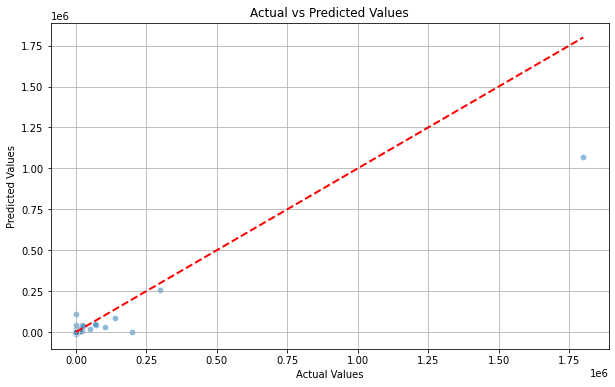

In [43]:
# Plotting predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolors='w', linewidth=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.grid(True)
plt.show()

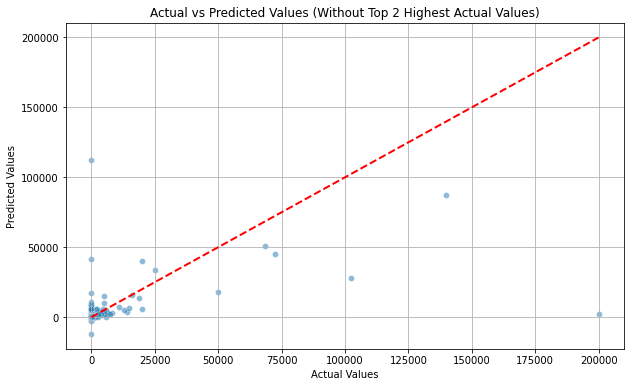

In [44]:
# Combine actual and predicted values into a DataFrame
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Identify the 2 highest actual values
top_2_highest_actuals = results_df['Actual'].nlargest(2)

# Filter out the rows with these highest actual values
filtered_results_df = results_df[~results_df['Actual'].isin(top_2_highest_actuals)]

# Plotting predicted vs actual values without the outliers
plt.figure(figsize=(10, 6))
plt.scatter(filtered_results_df['Actual'], filtered_results_df['Predicted'], alpha=0.5, edgecolors='w', linewidth=0.5)
plt.plot([min(filtered_results_df['Actual']), max(filtered_results_df['Actual'])],
         [min(filtered_results_df['Actual']), max(filtered_results_df['Actual'])], color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Without Top 2 Highest Actual Values)')
plt.grid(True)
plt.show()

In [45]:
from typing import Optional, Tuple

def snake_to_title(col_name: str) -> str:
    return col_name.replace('_', ' ').capitalize()


def kde_boxen_qq(
    dataframe: pd.DataFrame, col_name: str,
    title: Optional[str] = None,
    figsize: Optional[Tuple[str, str]] = None
    # It's not good practice to "inherit" figsize without actual inheritance or composition
) -> None:

    if title is None:
        title = snake_to_title(col_name)

    fig, axes = plt.subplot_mosaic([['up', 'right'],['down', 'right']],
                                    constrained_layout=True, figsize=(10,6),
                                    gridspec_kw={
                                        'height_ratios': (0.3, 0.7),
                                        'width_ratios': (0.6, 0.4)
                                    })
    
    fig.suptitle(title, fontsize='xx-large')

    sns.histplot(data=dataframe, x=col_name, ax=axes['down'], kde=True)

    sns.boxenplot(data=dataframe, x=col_name, ax=axes['up'])
    axes['up'].set_xlabel('')
    axes['up'].set_xticklabels('')

    sm.qqplot(dataframe[col_name], fit=True, line='45', alpha=0.2, ax=axes['right'])
    axes['right'].set_title('QQ plot')

    if figsize:
        x, y = figsize
        fig.set_figwidth(x)
        fig.set_figheight(y)

    sns.despine()
    plt.show()

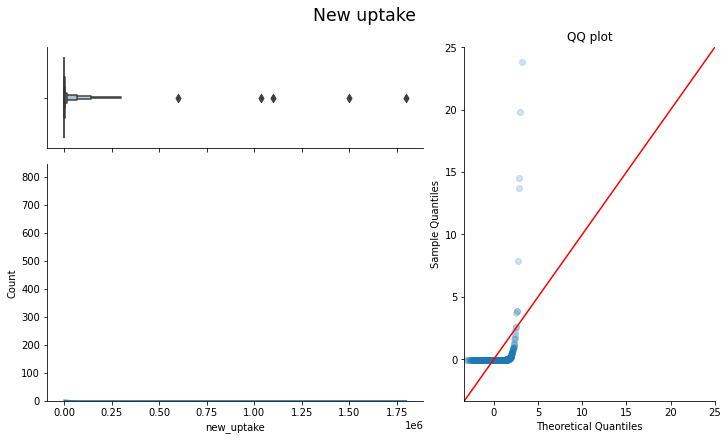

In [46]:
kde_boxen_qq(catboost_regresson_df, 'new_uptake')

<Axes: xlabel='new_uptake', ylabel='Density'>

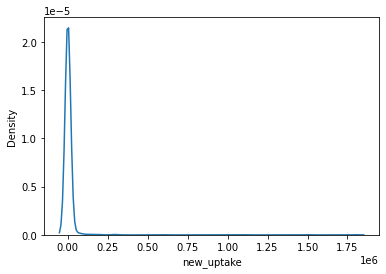

In [47]:
sns.kdeplot(catboost_regresson_df, x='new_uptake')

In [48]:
threshold = 0.25 * 1e6
(catboost_regresson_df['new_uptake'] > threshold).sum()

8

# Regression without outliers

In [49]:
def remove_rows_above_threshold(df, column_name, threshold):
    """
    Removes rows from the DataFrame where the values in the specified column are higher than the given threshold.

    Parameters:
    df (pd.DataFrame): The DataFrame to filter.
    column_name (str): The name of the column to check.
    threshold (float): The threshold value.

    Returns:
    pd.DataFrame: A DataFrame with rows removed where values exceed the threshold.
    """
    # Ensure the column exists in the DataFrame
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame")

    # Remove rows where values in the specified column are higher than the threshold
    filtered_df = df[df[column_name] <= threshold]
    
    return filtered_df

In [50]:
catboost_regresson_df = remove_rows_above_threshold(catboost_regresson_df, 'new_uptake', 0.25 * 1e6)

In [51]:
# Define the features and target
X = catboost_regresson_df.drop(columns=['new_uptake'])
y = catboost_regresson_df['new_uptake']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [52]:
# Custom transformer to extract amino acids at each position
class SequencePositionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, max_len=40):
        self.max_len = max_len
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = []
        for seq in X:
            if len(seq) > self.max_len:
                seq = seq[:self.max_len]  # Truncate sequences longer than max_len
            seq_padded = seq.ljust(self.max_len, 'X')  # Pad sequences shorter than max_len with 'X'
            X_transformed.append(list(seq_padded))
        return X_transformed

# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('seq', Pipeline(steps=[
            ('seq_pos', SequencePositionTransformer(max_len=40)),  # Adjust max_len if needed
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), sequence_col),
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ],
    remainder='passthrough'  # Pass through any columns not specified
)

In [53]:
# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(silent=True))
])

In [54]:
# Fit the pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
 ColumnTransformer(remainder='passthrough',
 transformers=[('seq',
 Pipeline(steps=[('seq_pos',
 SequencePositionTransformer()),
 ('onehot',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False))]),
 'cleaned_sequence'),
 ('num',
 Pipeline(steps=[('scaler',
 StandardScaler())]),
 ['molecular_weight',
 'aromaticity',
 'instability_index...
 'sheet_fraction',
 'molar_extinction_coefficient_reduced',
 'molar_extinction_coefficient_oxidized',
 'gravy', 'charge_at_ph',
 'sequence_len', 'Time',
 'Temp.', 'nht_tail',
 'acylated_terminal']),
 ('cat',
 Pipeline(steps=[('onehot',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False))]),
 ['Cell line'])])),
 ('regressor',
 <catboost.core.CatBoostRegressor object at 0x7f08bcafc1f0>)]) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. Pipeline Pipeline(steps=[('preprocessor',
 ColumnTransformer(remainder='passthrough',
 transformers=[('seq',
 Pipeline(steps=[('seq_pos',
 SequencePositionTransformer()),
 ('onehot',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False))]),
 'cleaned_sequence'),
 ('num',
 Pipeline(steps=[('scaler',
 StandardScaler())]),
 ['molecular_weight',
 'aromaticity',
 'instability_index...
 'sheet_fraction',
 'molar_extinction_coefficient_reduced',
 'molar_extinction_coefficient_oxidized',
 'gravy', 'charge_at_ph',
 'sequence_len', 'Time',
 'Temp.', 'nht_tail',
 'acylated_terminal']),
 ('cat',
 Pipeline(steps=[('onehot',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False))]),
 ['Cell line'])])),
 ('regressor',
 <catboost.core.CatBoostRegressor object at 0x7f08bcafc1f0>)]) preprocessor: ColumnTransformer ColumnTransformer(remainder='passthrough',
 transformers=[('seq',
 Pipeline(steps=[('seq_pos',
 SequencePositionTransformer()),
 ('onehot',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False))]),
 'cleaned_sequence'),
 ('num',
 Pipeline(steps=[('scaler', StandardScaler())]),
 ['molecular_weight', 'aromaticity',
 'instability_index', 'isoelectric_point',
 'helix_fraction', 'turn_fraction',
 'sheet_fraction',
 'molar_extinction_coefficient_reduced',
 'molar_extinction_coefficient_oxidized',
 'gravy', 'charge_at_ph', 'sequence_len',
 'Time', 'Temp.', 'nht_tail',
 'acylated_terminal']),
 ('cat',
 Pipeline(steps=[('onehot',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False))]),
 ['Cell line'])]) seq cleaned_sequence SequencePositionTransformer SequencePositionTransformer() OneHotEncoder OneHotEncoder(handle_unknown='ignore', sparse_output=False) num ['molecular_weight', 'aromaticity', 'instability_index', 'isoelectric_point', 'helix_fraction', 'turn_fraction', 'sheet_fraction', 'molar_extinction_coefficient_reduced', 'molar_extinction_coefficient_oxidized', 'gravy', 'charge_at_ph', 'sequence_len', 'Time', 'Temp.', 'nht_tail', 'acylated_terminal'] StandardScaler StandardScaler() cat ['Cell line'] OneHotEncoder OneHotEncoder(handle_unknown='ignore', sparse_output=False) remainder ['R_percentage', 'K_percentage', 'S_percentage', 'E_percentage'] passthrough passthrough CatBoostRegressor <catboost.core.CatBoostRegressor object at 0x7f08bcafc1f0>

In [55]:
# Predict on test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

Mean Absolute Error: 1716.3595039737743
R^2 Score: 0.28865958933539326


In [56]:
def objective(trial):
    # Define hyperparameters to tune
    params = {
        "iterations": 500,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    # Create the pipeline with tuned CatBoostRegressor
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', CatBoostRegressor(**params, silent=True))
    ])

    # Cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    # Use 'neg_mean_squared_error' for regression
    mse_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='neg_mean_squared_error')

    # Return the negative of the mean MSE across all folds (since cross_val_score returns negative MSE)
    return -np.mean(mse_scores)

In [58]:
# Run the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Print the best parameters found
print('Best parameters:', study.best_params)
print('Best value (negative MSE):', study.best_value)

Best parameters: {'learning_rate': 0.037696935007989374, 'depth': 7, 'subsample': 0.268992969369074, 'colsample_bylevel': 0.09392782600152243, 'min_data_in_leaf': 26}
Best value (negative MSE): 109712840.93210241


[I 2024-07-22 20:46:54,534] A new study created in memory with name: no-name-8aaf691f-4853-4d2e-8ea3-40a2b1626d48
[I 2024-07-22 20:47:08,746] Trial 0 finished with value: 109712840.93210241 and parameters: {'learning_rate': 0.037696935007989374, 'depth': 7, 'subsample': 0.268992969369074, 'colsample_bylevel': 0.09392782600152243, 'min_data_in_leaf': 26}. Best is trial 0 with value: 109712840.93210241.
[I 2024-07-22 20:47:18,515] Trial 1 finished with value: 117984727.54868142 and parameters: {'learning_rate': 0.02031031311568346, 'depth': 6, 'subsample': 0.8931076032846623, 'colsample_bylevel': 0.0961463541493828, 'min_data_in_leaf': 85}. Best is trial 0 with value: 109712840.93210241.
[I 2024-07-22 20:47:40,585] Trial 2 finished with value: 116008709.69492054 and parameters: {'learning_rate': 0.06128689148602604, 'depth': 8, 'subsample': 0.7600123693442699, 'colsample_bylevel': 0.40663494732299826, 'min_data_in_leaf': 46}. Best is trial 0 with value: 109712840.93210241.
[I 2024-07-22 

In [42]:
BEST_REGRESSION_PARAMS = {
    'learning_rate': 0.037696935007989374,
    'depth': 7,
    # 'subsample': 0.268992969369074,
    'colsample_bylevel': 0.09392782600152243,
    'min_data_in_leaf': 26
}

In [43]:
from sklearn.metrics import mean_absolute_error, r2_score

best_params = BEST_REGRESSION_PARAMS
final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CatBoostRegressor(**best_params, silent=True))
])
final_model.fit(X_train, y_train)

# Predict on test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

Mean Absolute Error: 0.1024
R^2 Score: 0.587654371894522
